<a href="https://colab.research.google.com/github/Jithran-07/Air-Quality-Prediction/blob/main/MLSTM_Nadam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the dataset from a CSV file
input_file = '/content/Air Quality Prediction Indian Dataset.csv'  # Replace with the path to your CSV file
output_file = '/content/labeled.csv'  # Replace with the desired output path

# Read the CSV file into a Pandas DataFrame
data = pd.read_csv(input_file)

# Specify the columns to encode
columns_to_encode = ['City','AQI_Bucket']  # Replace with the names of the categorical columns

# Create a LabelEncoder for each categorical column
label_encoders = {}

for column in columns_to_encode:
    label_encoder = LabelEncoder()
    data[column] = label_encoder.fit_transform(data[column])
    label_encoders[column] = label_encoder

# Save the encoded data to a new CSV file
data.to_csv(output_file, index=False)

print("Label encoding complete. Encoded data saved to", output_file)


Label encoding complete. Encoded data saved to /content/labeled.csv


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dataset from a CSV file
input_file = '/content/labeled.csv'  # Replace with the path to your CSV file
output_file = '/content/normalized.csv'  # Replace with the desired output path

# Read the CSV file into a Pandas DataFrame
data = pd.read_csv(input_file)

# Select numeric columns for normalization (you can customize this based on your dataset)
numeric_columns = data.select_dtypes(include=['number']).columns

# Create a MinMaxScaler
scaler = MinMaxScaler()

# Normalize the selected columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Save the normalized data to a new CSV file
data.to_csv(output_file, index=False)

print("Normalization complete. Normalized data saved to", output_file)


Normalization complete. Normalized data saved to /content/normalized.csv


In [ ]:
import pandas as pd


# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/content/normalized.csv')

df.drop(df.columns[1], axis=1, inplace=True)
X = df.iloc[:, :-1]   # data without class label
Y = df.iloc[:, 14].values     # class label values only

print("\n=================================================\nDataset after drop one column\n=================================================\n",df)




Dataset after drop one column
       City     PM2.5      PM10        NO       NO2       NOx       NH3  \
0      0.0  0.124610  0.147894  0.007486  0.145214  0.053189  0.063633   
1      0.0  0.119776  0.153673  0.006353  0.184500  0.065559  0.060992   
2      0.0  0.136160  0.161606  0.039945  0.219143  0.096463  0.076780   
3      0.0  0.097585  0.122028  0.014531  0.199286  0.075205  0.067835   
4      0.0  0.110595  0.135652  0.031327  0.164500  0.073330  0.072818   
...    ...       ...       ...       ...       ...       ...       ...   
6231   1.0  0.008836  0.031011  0.035604  0.165000  0.076009  0.066214   
6232   1.0  0.020433  0.054671  0.046738  0.177786  0.086504  0.074139   
6233   1.0  0.035123  0.084009  0.019941  0.184929  0.073062  0.071257   
6234   1.0  0.032816  0.073415  0.020130  0.209714  0.081100  0.063573   
6235   1.0  0.022976  0.053442  0.023904  0.207786  0.083199  0.059491   

            CO       SO2        O3   Benzene   Toluene    Xylene       AQI  \
0

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, shuffle=False)

print("\n========================================\nTraining Dataset class label values only\n========================================\n",X_train)
print("\n========================================\nTraining Dataset class label values only\n========================================\n",Y_train)
print("\n===================================\nTesting Dataset without class label\n===================================\n",X_test)
print("\n=============================================\nActual class label values for Testing Dataset\n=============================================\n",Y_test)


Training Dataset class label values only
       City     PM2.5      PM10        NO       NO2       NOx       NH3  \
0     0.00  0.124610  0.147894  0.007486  0.145214  0.053189  0.063633   
1     0.00  0.119776  0.153673  0.006353  0.184500  0.065559  0.060992   
2     0.00  0.136160  0.161606  0.039945  0.219143  0.096463  0.076780   
3     0.00  0.097585  0.122028  0.014531  0.199286  0.075205  0.067835   
4     0.00  0.110595  0.135652  0.031327  0.164500  0.073330  0.072818   
...    ...       ...       ...       ...       ...       ...       ...   
4672  0.75  0.102261  0.163266  0.095867  0.278786  0.242408  0.110037   
4673  0.75  0.109716  0.177650  0.288922  0.343214  0.396258  0.098871   
4674  0.75  0.182583  0.270898  0.213625  0.404857  0.393891  0.099352   
4675  0.75  0.218475  0.300362  0.098132  0.371143  0.302831  0.107756   
4676  0.75  0.135077  0.218457  0.155438  0.401071  0.361826  0.114059   

            CO       SO2        O3   Benzene   Toluene    Xylene    

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class MLSTMCell(Layer):
    def __init__(self, units):
        super(MLSTMCell, self).__init__()
        self.units = units
        self.state_size = (units, units)  # Tuple representing (hidden state size, cell state size)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernel = self.add_weight("kernel", (input_dim, self.units * 2))
        self.recurrent_kernel = self.add_weight("recurrent_kernel", (self.units, self.units * 2))

    def call(self, inputs, states):
        h_tm1, c_tm1 = states  # Previous hidden state and cell state

        # Multiplicative interaction
        z = tf.matmul(inputs, self.kernel) * tf.matmul(h_tm1, self.recurrent_kernel)

        # Split z into two parts: update gate and new candidate values
        z1, z2 = tf.split(z, num_or_size_splits=2, axis=-1)
        update_gate = tf.sigmoid(z1)
        candidate = tf.tanh(z2)

        # Update the cell state and hidden state
        c = (1 - update_gate) * c_tm1 + update_gate * candidate
        h = tf.tanh(c)

        return h, [h, c]


In [ ]:
# Define the MLSTM model
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import Sequential

model = Sequential()

# Reshape the input data for the MLSTM layer
model.add(Reshape((1, X_train.shape[1]), input_shape=(X_train.shape[1],)))

# Add an MLSTM layer
mlstm_units = 64
model.add(tf.keras.layers.RNN(MLSTMCell(mlstm_units), return_sequences=False))

# Add a dense output layer (adjust units and activation function as needed)
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='nadam', loss='mean_squared_error')


In [ ]:
# Train the model
epochs = 50
batch_size = 32
history=model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/50
117/117 [==============================] - 3s 9ms/step - loss: 0.2220 - val_loss: 0.1261
Epoch 2/50
117/117 [==============================] - 1s 5ms/step - loss: 0.1550 - val_loss: 0.0869
Epoch 3/50
117/117 [==============================] - 0s 4ms/step - loss: 0.1150 - val_loss: 0.0677
Epoch 4/50
117/117 [==============================] - 0s 3ms/step - loss: 0.0934 - val_loss: 0.0607
Epoch 5/50
117/117 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.0596
Epoch 6/50
117/117 [==============================] - 0s 3ms/step - loss: 0.0787 - val_loss: 0.0607
Epoch 7/50
117/117 [==============================] - 0s 3ms/step - loss: 0.0771 - val_loss: 0.0620
Epoch 8/50
117/117 [==============================] - 0s 3ms/step - loss: 0.0765 - val_loss: 0.0632
Epoch 9/50
117/117 [==============================] - 0s 3ms/step - loss: 0.0764 - val_loss: 0.0636
Epoch 10/50
117/117 [==============================] - 0s 3ms/step - loss: 0.0764 - val_loss: 0.0640

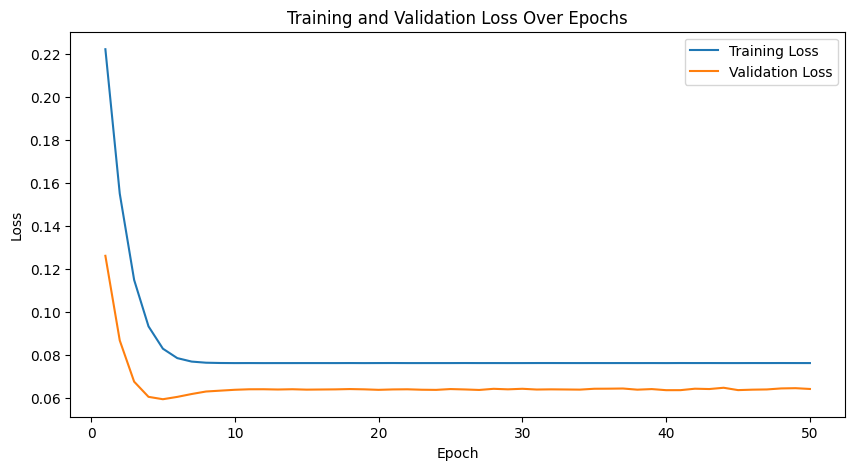

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and validation loss from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Display the plot

plt.show()


In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

49/49 [==============================] - 0s 2ms/step
[[0.4320959]
 [0.4320959]
 [0.4320959]
 ...
 [0.4320959]
 [0.4320959]
 [0.4320959]]


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mae = mean_absolute_error(Y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error: 0.21
Root Mean Squared Error (RMSE): 0.23
